In [2]:
import numpy as np
from scipy import linalg as la
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def compute_view_matrix(position, target, up):
    '''
    Inputs: 
        position : 3D coordinates of the camera center in world coordinates
        target : 3D coordinates of the camera target in world coordinates
        up : vector specifying the up direction of the camera. should be orthogonal to (target-position)
    Outputs:
        P : 3 x 4 camera extrinsic matrix, a concatenation of rotation matrix and translation matrix
    '''
    L = target - position
    L = L / np.linalg.norm(L)
    s = np.cross(L, up)
    s = s / np.linalg.norm(s)
    u_prime = np.cross(s,L)
    R = np.r_[s,u_prime,-L].reshape((3,3))
    T = -R @ position
    P = np.c_[R,T]
    return P

def project(position,target,up,X):
    '''
    Given camera extrinsic details, and 3D points X, 
    return the homogenous coordinates of Y,
    which are projected into the camera plane.
    See compute_view_matrix() details
    '''
    P = compute_view_matrix(position,target,up)
    if len(X.shape) > 1:
        _,n = X.shape
        Y = P @ np.r_[X,np.ones((1,n))]
        Y /= Y[2,:]
        return Y,P
    else:
        Y = P @ np.r_[X,1]
        Y /= Y[2]
        return Y,P

def fundamental_matrix(Y,Yp):
    '''
    Inputs:
        Y : all keypoints from camera 1 in homogenous coordinates in a (3 x n_kp) matrix
        Yp : same from camera 2
    Outputs:
        F : fundamental matrix between stereo cameras
    Desc:
        Solved using the 7-point algorithm. It is assumed that matching keypoints are aligned
        by column. At least 7 matches required. 
    TODO: 
        Implement normalized version. Camera intrinsics needed?
    '''
    n = Y.shape[1]
    X = np.zeros((n,9))
    for i in range(n):
        X[i] = np.outer(Yp[:,i],Y[:,i]).flatten()
        
    U,S,Vh = la.svd(X)
    F = Vh[len(Vh)-1].reshape((3,3))
    U,S,Vh = la.svd(F)
    S[2] = 0
    F = U @ np.diag(S) @ Vh
    return F

In [17]:
def correct_f_translation(x1, x2, F0):
    T1 = np.eye(3)
    T1[:2,2] = x1[:2]
    T2 = np.eye(3)
    T2[:2,2] = x2[:2]
    F = T2.T @ F0 @ T1
    return T1, T2, F

In [30]:
def correct_f_rotation(F0):
    # Compute left epipole
    U,S,Vh = la.svd(F0.T)
    e1 = Vh[2,:]
    # Compute right epipole
    U,S,Vh = la.svd(F0)
    e2 = Vh[2,:]
    
    # Use epipoles to form rotation matrices
    print(e1, e2)
    R1 = np.eye(3)
    R1[0,0] = e1[0]
    R1[0,1] = e1[1]
    R1[1,0] = -e1[1]
    R1[1,1] = e1[0]
    
    R2 = np.eye(3)
    R2[0,0] = e2[0]
    R2[0,1] = e2[1]
    R2[1,0] = -e2[1]
    R2[1,1] = e2[0]
    F = R2 @ F0 @ R1.T
    return R1, R2, F

In [6]:
def correct_f(x1,x2,F0):
    T1, T2, F_ = correct_f_translation(x1,x2,F0)
    R1, R2, F = correct_f_rotation(F_)
    
    return F

In [12]:
# n Target points 
n = 10
X = np.random.uniform(-3,3,(3,n))

cam1_pos = np.array([-5,-5,0])
cam1_tgt = np.array([0,0,0])
cam1_up = np.array([0,0,1])
Y1,_ = project(cam1_pos, cam1_tgt, cam1_up, X)

cam2_pos = np.array([-5,5,1])
cam2_tgt = np.array([0,0,0])
cam2_up = np.array([0,-1,5])
Y2,_ = project(cam2_pos, cam2_tgt, cam2_up, X)

F0 = fundamental_matrix(Y1,Y2)

<Figure size 432x288 with 0 Axes>

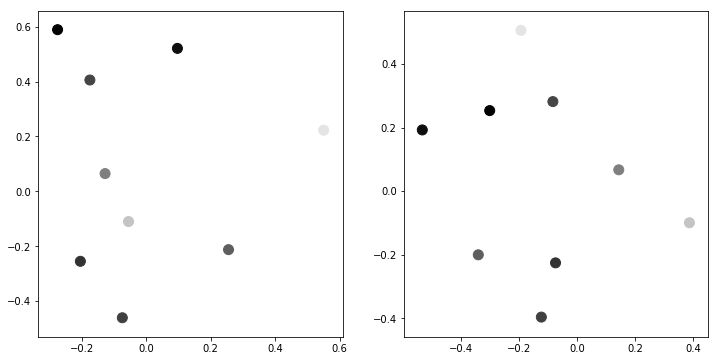

In [13]:
plt.gray()
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.scatter(Y1[0,:],Y1[1,:],c=X[1,:],s=100)
ax = fig.add_subplot(122)
ax.scatter(Y2[0,:],Y2[1,:],c=X[1,:],s=100)
plt.show()

In [31]:
y1 = Y1[:,0]
y2 = Y2[:,0]
F = correct_f(y1,y2,F0)

[ 0.63744169  0.29760519 -0.71070334] [-0.71798865  0.33398818 -0.61069157]


In [32]:
print(F)

[[-2.02976714e-03 -2.79093042e-01 -3.91510628e-01]
 [-2.77971064e-01 -4.89507390e-04  3.28828696e-01]
 [ 2.67704685e-01  2.24844426e-01  3.05311332e-16]]


In [34]:
 3.28828696e-01 * -0.71070334

-0.23369965253504463